In [3]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import FrechetCellFilter
from ase.optimize import BFGS
from ase.io import read
from tqdm import tqdm
from ase.lattice.cubic import FaceCenteredCubic, BodyCenteredCubic
from ase.visualize import view

import os
import numpy as np

atoms = BodyCenteredCubic('W')
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")
opt = BFGS(atoms)
atoms.calc = calc
opt.run(fmax=0.01, steps=500)
cell = atoms.get_cell()


vol_energy_dict = {}
for x in tqdm(np.linspace(0.95, 1.05, 5)):
    atoms.set_cell(cell * x, scale_atoms=True)
    calc.relax_cell = False
    atoms.calc = calc
    opt = BFGS(atoms)
    opt.run(fmax=0.01, steps=500)
    per_atom_energy = atoms.get_potential_energy() / len(atoms)
    per_atom_volume = atoms.get_volume() / len(atoms)
    vol_energy_dict[per_atom_volume] = per_atom_energy

      Step     Time          Energy          fmax
BFGS:    0 19:24:25      -25.894567        0.000000


  0%|          | 0/5 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:24:25      -24.844161        0.000000


 20%|██        | 1/5 [00:00<00:00,  7.81it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:24:25      -25.591796        0.000000


 40%|████      | 2/5 [00:00<00:00,  7.90it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:24:25      -25.894567        0.000000


 60%|██████    | 3/5 [00:00<00:00,  7.90it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:24:26      -25.827781        0.000000


 80%|████████  | 4/5 [00:00<00:00,  7.94it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:24:26      -25.488111        0.000000


100%|██████████| 5/5 [00:00<00:00,  7.60it/s]


<>:11: SyntaxWarning: invalid escape sequence '\A'
<>:11: SyntaxWarning: invalid escape sequence '\A'
/var/folders/1f/_0ghpkvx4c14xmf15m39z5fr0000gn/T/ipykernel_38045/2685348117.py:11: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel("volume ($\AA^3$/atom)")  # Set the x-label


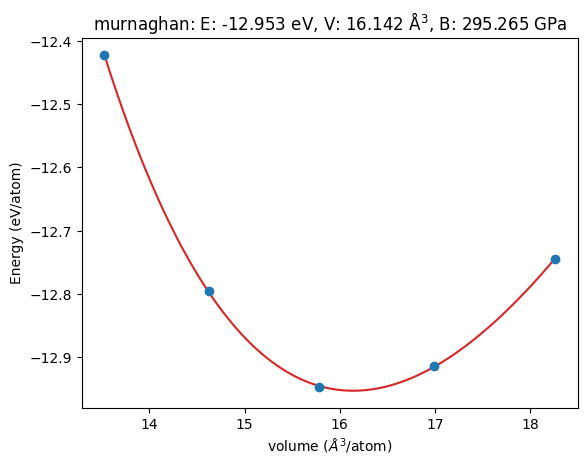

In [4]:
from ase.eos import EquationOfState
import matplotlib.pyplot as plt
eos = EquationOfState(list(vol_energy_dict.keys()), list(vol_energy_dict.values()),eos='murnaghan')
v0, e0, B = eos.fit()

# Plot and get the figure
fig = eos.plot()

# Get the current axis and set the labels
ax = plt.gca()  # Get the current axis
ax.set_xlabel("volume ($\AA^3$/atom)")  # Set the x-label
ax.set_ylabel("Energy (eV/atom)")  # Set the y-label

# Show the plot
plt.show()

## Shear modulus

In [4]:
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.optimize import BFGS
from ase.io import read
from ase.lattice.cubic import BodyCenteredCubic
from tqdm import tqdm
import numpy as np

# Initialize Ta BCC structure
atoms = BodyCenteredCubic('Ta')

# Load pretrained MLP
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")
atoms.calc = calc

# Relax initial structure
opt = BFGS(atoms)
opt.run(fmax=0.01, steps=500)

# Save relaxed cell
cell = atoms.get_cell()

# Shear strain applied on xy-plane (γ_xy)
# Strain matrix for simple shear: [[1, γ, 0], [0, 1, 0], [0, 0, 1]]
shear_strains = np.linspace(-0.01, 0.01, 5)

energy_dict = {}

for gamma in tqdm(shear_strains, desc="Applying shear strain"):
    strain_matrix = np.array([[1, gamma, 0],
                              [0, 1, 0],
                              [0, 0, 1]])
    
    # Apply shear to the cell
    new_cell = np.dot(cell, strain_matrix)
    atoms.set_cell(new_cell, scale_atoms=True)

    # Relax internal atomic positions only (not cell)
    calc.relax_cell = False
    atoms.calc = calc
    opt = BFGS(atoms)
    opt.run(fmax=0.01, steps=500)

    # Store energy per atom vs applied shear
    per_atom_energy = atoms.get_potential_energy() / len(atoms)
    energy_dict[gamma] = per_atom_energy

# Print results
print("\nShear strain vs energy per atom:")
for gamma, energy in energy_dict.items():
    print(f"γ_xy = {gamma:+.3f} → E = {energy:.6f} eV/atom")


      Step     Time          Energy          fmax
BFGS:    0 16:26:44      -23.626457        0.000000


Applying shear strain:   0%|          | 0/5 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 16:26:44      -23.625699        0.000000


Applying shear strain:  20%|██        | 1/5 [00:00<00:00,  5.51it/s]

      Step     Time          Energy          fmax
BFGS:    0 16:26:44      -23.626267        0.000000


Applying shear strain:  40%|████      | 2/5 [00:00<00:00,  6.15it/s]

      Step     Time          Energy          fmax
BFGS:    0 16:26:44      -23.626457        0.000000


Applying shear strain:  60%|██████    | 3/5 [00:00<00:00,  5.78it/s]

      Step     Time          Energy          fmax
BFGS:    0 16:26:44      -23.626268        0.000000


Applying shear strain:  80%|████████  | 4/5 [00:00<00:00,  6.06it/s]

      Step     Time          Energy          fmax
BFGS:    0 16:26:44      -23.625699        0.000000


Applying shear strain: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Shear strain vs energy per atom:
γ_xy = -0.010 → E = -11.812849 eV/atom
γ_xy = -0.005 → E = -11.813134 eV/atom
γ_xy = +0.000 → E = -11.813229 eV/atom
γ_xy = +0.005 → E = -11.813134 eV/atom
γ_xy = +0.010 → E = -11.812850 eV/atom


<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
/var/folders/1f/_0ghpkvx4c14xmf15m39z5fr0000gn/T/ipykernel_24456/3987448870.py:5: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Shear strain ($\gamma_{xy}$)", fontsize=14)


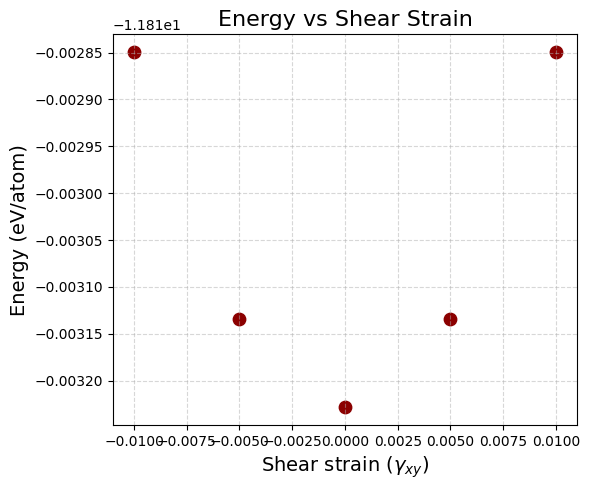

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(energy_dict.keys(), energy_dict.values(), color='darkred', s=80)
plt.xlabel("Shear strain ($\gamma_{xy}$)", fontsize=14)
plt.ylabel("Energy (eV/atom)", fontsize=14)
plt.title("Energy vs Shear Strain", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Calculate the Shear Modulus

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Convert dict to arrays
gammas = np.array(list(energy_dict.keys()))
energies = np.array(list(energy_dict.values()))

# Fit a quadratic curve: E = a*γ^2 + b*γ + c
coeffs = np.polyfit(gammas, energies, 2)
a, b, c = coeffs

# Compute shear modulus from curvature
# G = (1/V0) * d²E/dγ² / 2 = a * 2 * V0
V0 = atoms.get_volume() / len(atoms)
G = a * 2 / V0  # eV/Å³

# Convert to GPa: 1 eV/Å³ = 160.21766208 GPa
G_GPa = G * 160.21766208

print(f"Fitted quadratic coefficients: a={a:.6e}, b={b:.6e}, c={c:.6e}")
print(f"Equilibrium volume per atom: {V0:.4f} Å³")
print(f"Shear modulus: {G_GPa:.2f} GPa")

Fitted quadratic coefficients: a=3.789834e+00, b=-7.152557e-06, c=-1.181323e+01
Equilibrium volume per atom: 18.1323 Å³
Shear modulus: 66.97 GPa


Applying shear: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


Stress-fit slope (eV/Å^3): 0.3970554301079798
Shear modulus from stress slope: 63.62 GPa
Energy curvature a (eV): 3.789662570804417
Shear modulus from energy curvature: 66.97 GPa
Equilibrium V/atom ~ 18.1323 Å^3


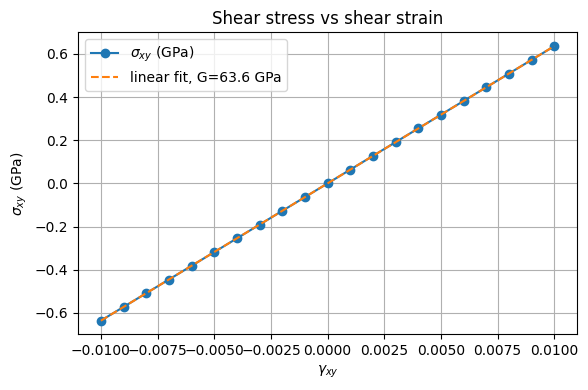

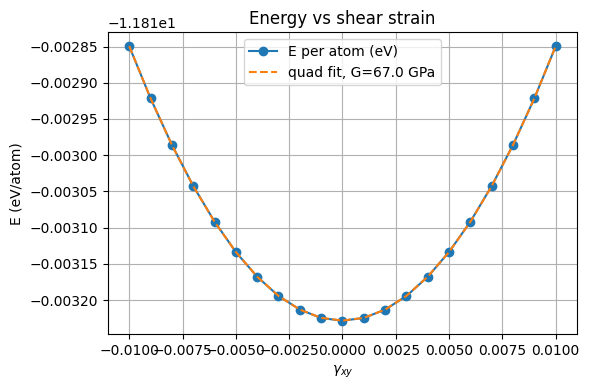

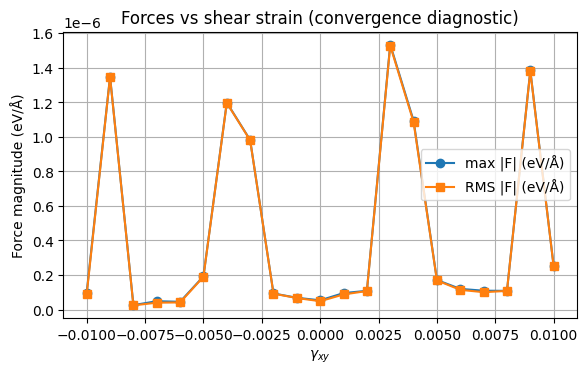

gamma=-0.0100: maxF=9.8219e-08, meanF=8.8471e-08
gamma=-0.0090: maxF=1.3481e-06, meanF=1.3447e-06
gamma=-0.0080: maxF=2.5374e-08, meanF=2.3819e-08
gamma=-0.0070: maxF=4.8034e-08, meanF=3.8228e-08
gamma=-0.0060: maxF=4.4694e-08, meanF=4.0739e-08
gamma=-0.0050: maxF=1.9173e-07, meanF=1.8935e-07
gamma=-0.0040: maxF=1.1979e-06, meanF=1.1954e-06


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ase.optimize import BFGS
from ase.lattice.cubic import BodyCenteredCubic
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# --- user params ----------------------------------------------------------
num_points = 21                  # more points for smooth curves
max_gamma = 0.01                 # ±1% shear
fmax_relax = 0.001               # tighter force tolerance for diagnostic
bfgs_steps = 2000
relax_internal = True            # relax atomic positions after imposing strain
# -------------------------------------------------------------------------

# Initialize Ta BCC
atoms = BodyCenteredCubic('Ta')   # default conventional cell; adjust if you prefer supercell
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

# Relax initial structure first (fully)
atoms.calc = calc
opt = BFGS(atoms, logfile=None)
opt.run(fmax=0.0001, steps=bfgs_steps)

cell0 = atoms.get_cell().copy()
V0_per_atom = atoms.get_volume() / len(atoms)

# shear values
shear_strains = np.linspace(-max_gamma, max_gamma, num_points)

# storage
gammas = []
energies = []
sigma_xy = []            # stress[0,1]
max_forces = []          # max norm of forces per step
rms_forces = []
all_forces = []          # optional: store per-atom forces for a few gammas
volumes = []

for gamma in tqdm(shear_strains, desc="Applying shear"):
    # create simple shear on xy: new_cell = cell0 · [[1, γ, 0],[0,1,0],[0,0,1]]
    strain_matrix = np.array([[1.0, gamma, 0.0],
                              [0.0, 1.0, 0.0],
                              [0.0, 0.0, 1.0]])
    new_cell = np.dot(cell0, strain_matrix)
    atoms.set_cell(new_cell, scale_atoms=True)   # keep fractional pos
    atoms.calc = calc
    # ensure cell is fixed for internal relax
    calc.relax_cell = False

    if relax_internal:
        opt = BFGS(atoms, logfile=None)
        opt.run(fmax=fmax_relax, steps=bfgs_steps)

    # energy (eV/atom)
    E_per_atom = atoms.get_potential_energy() / len(atoms)
    energies.append(E_per_atom)

    # stress tensor (3x3) in eV/Å^3 (ASE convention)
    stress = atoms.get_stress(voigt=False)      # 3x3 array
    sx_y = float(stress[0,1])                   # σ_xy
    sigma_xy.append(sx_y)

    # forces
    forces = atoms.get_forces()                 # N×3, eV/Å
    fnorms = np.linalg.norm(forces, axis=1)
    max_forces.append(float(fnorms.max()))
    rms_forces.append(float(np.sqrt((fnorms**2).mean())))

    # optionally store per-atom forces for a few gamma values for later inspection
    if len(all_forces) < 7:
        all_forces.append((gamma, forces.copy()))

    gammas.append(gamma)
    volumes.append(atoms.get_volume() / len(atoms))

# convert arrays
gammas = np.array(gammas)
energies = np.array(energies)
sigma_xy = np.array(sigma_xy)   # in eV/Å^3

# Unit conversions
EVA3_to_GPa = 160.21766208
sigma_xy_GPa = sigma_xy * EVA3_to_GPa

# --- Fit stress-vs-strain to get G (stress route) --------------------------
coeffs_stress = np.polyfit(gammas, sigma_xy, 1)
slope_stress = coeffs_stress[0]          # dσ/dγ in eV/Å^3
G_from_stress_GPa = slope_stress * EVA3_to_GPa

# --- Fit energy-vs-strain curvature to get G (energy route) -------------
# fit quadratic around center; use np.polyfit deg=2
coeffs_energy = np.polyfit(gammas, energies, 2)
a = coeffs_energy[0]   # a in E = a*γ^2 + b*γ + c

# G = (1/V0) * d2E/dγ2 / 2. Here d2E/dγ2 = 2a, so G = (1/V0) * (2a) / 2 = a / V0
# note: E is eV/atom, V0 must be Å^3/atom
V0 = np.mean(volumes)
G_from_energy_eV_A3 = 2 * a / V0
G_from_energy_GPa = G_from_energy_eV_A3 * EVA3_to_GPa

# print results
print("Stress-fit slope (eV/Å^3):", slope_stress)
print(f"Shear modulus from stress slope: {G_from_stress_GPa:.2f} GPa")
print("Energy curvature a (eV):", a)
print(f"Shear modulus from energy curvature: {G_from_energy_GPa:.2f} GPa")
print(f"Equilibrium V/atom ~ {V0:.4f} Å^3")

# --- Plotting --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(gammas, sigma_xy_GPa, 'o-', label=r'$\sigma_{xy}$ (GPa)')
plt.xlabel(r'$\gamma_{xy}$')
plt.ylabel(r'$\sigma_{xy}$ (GPa)')
plt.title("Shear stress vs shear strain")
# linear fit line
fit_line = np.polyval([slope_stress, coeffs_stress[1]], gammas) * EVA3_to_GPa
plt.plot(gammas, fit_line, '--', label=f"linear fit, G={G_from_stress_GPa:.1f} GPa")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.plot(gammas, energies, 'o-', label='E per atom (eV)')
plt.xlabel(r'$\gamma_{xy}$')
plt.ylabel('E (eV/atom)')
plt.title("Energy vs shear strain")
# quadratic fit
quad_fit = np.polyval(coeffs_energy, gammas)
plt.plot(gammas, quad_fit, '--', label=f'quad fit, G={G_from_energy_GPa:.1f} GPa')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.plot(gammas, max_forces, 'o-', label='max |F| (eV/Å)')
plt.plot(gammas, rms_forces, 's-', label='RMS |F| (eV/Å)')
plt.xlabel(r'$\gamma_{xy}$')
plt.ylabel('Force magnitude (eV/Å)')
plt.title('Forces vs shear strain (convergence diagnostic)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Optional: inspect per-atom force patterns for stored gammas
for g, forces in all_forces:
    norms = np.linalg.norm(forces, axis=1)
    print(f"gamma={g:.4f}: maxF={norms.max():.4e}, meanF={norms.mean():.4e}")



--- Computing shear XY ---


Shear XY: 100%|██████████| 21/21 [00:02<00:00,  7.65it/s]



--- Computing shear YZ ---


Shear YZ: 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]



--- Computing shear XZ ---


Shear XZ: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


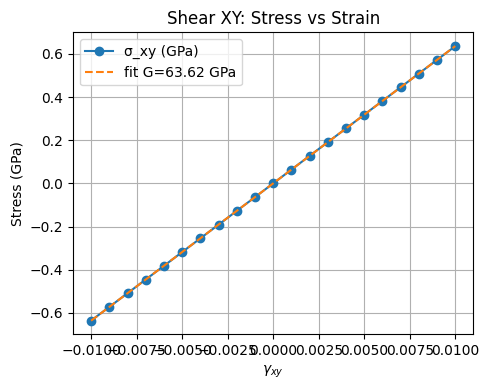

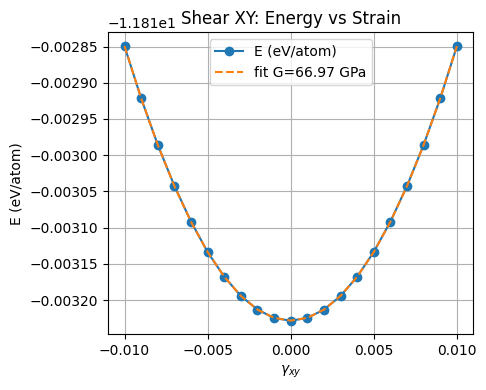

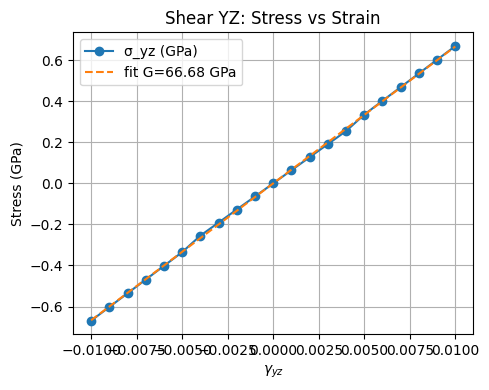

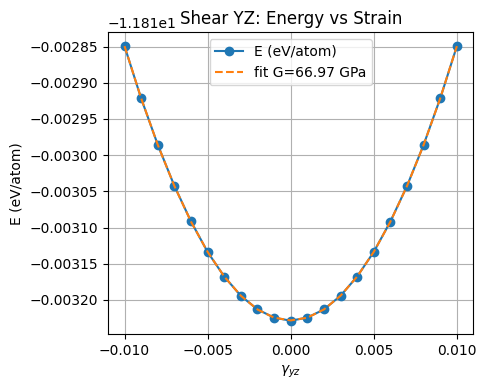

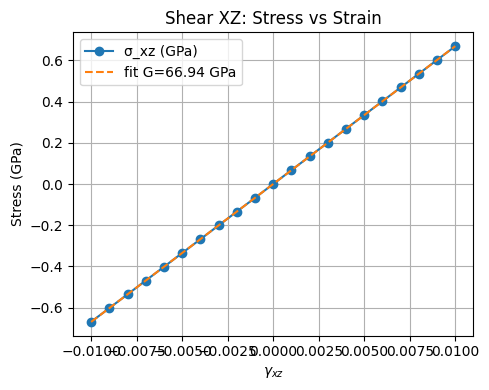

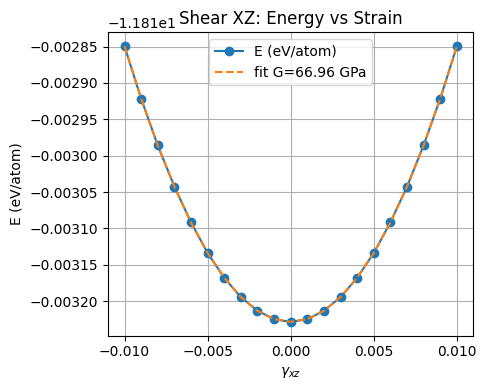


Summary of shear moduli (G, GPa):
   XY : from stress =    63.62 GPa, from energy =    66.97 GPa
   YZ : from stress =    66.68 GPa, from energy =    66.97 GPa
   XZ : from stress =    66.94 GPa, from energy =    66.96 GPa


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ase.optimize import BFGS
from ase.lattice.cubic import BodyCenteredCubic
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# --- user params ----------------------------------------------------------
num_points = 21
max_gamma = 0.01
fmax_relax = 0.001
bfgs_steps = 2000
relax_internal = True
# -------------------------------------------------------------------------

# Initialize Ta BCC
atoms = BodyCenteredCubic('Ta')
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

# Fully relax the structure
atoms.calc = calc
opt = BFGS(atoms, logfile=None)
opt.run(fmax=0.0001, steps=bfgs_steps)

cell0 = atoms.get_cell().copy()
V0_per_atom = atoms.get_volume() / len(atoms)
EVA3_to_GPa = 160.21766208

# Define shear types: (label, indices)
shear_types = [
    ("xy", (0, 1)),
    ("yz", (1, 2)),
    ("xz", (0, 2)),
]

results = {}

for label, (i, j) in shear_types:
    print(f"\n--- Computing shear {label.upper()} ---")

    gammas = np.linspace(-max_gamma, max_gamma, num_points)
    energies, sigmas = [], []
    volumes = []

    for gamma in tqdm(gammas, desc=f"Shear {label.upper()}"):
        strain = np.eye(3)
        strain[i, j] = gamma  # apply shear
        new_cell = np.dot(cell0, strain)

        atoms.set_cell(new_cell, scale_atoms=True)
        atoms.calc = calc
        calc.relax_cell = False

        if relax_internal:
            opt = BFGS(atoms, logfile=None)
            opt.run(fmax=fmax_relax, steps=bfgs_steps)

        E = atoms.get_potential_energy() / len(atoms)
        stress = atoms.get_stress(voigt=False)
        sigma_ij = float(stress[i, j])
        energies.append(E)
        sigmas.append(sigma_ij)
        volumes.append(atoms.get_volume() / len(atoms))

    # Fit results
    gammas = np.array(gammas)
    energies = np.array(energies)
    sigmas = np.array(sigmas)
    volumes = np.array(volumes)
    V0 = np.mean(volumes)

    # Stress fit
    coeffs_stress = np.polyfit(gammas, sigmas, 1)
    slope_stress = coeffs_stress[0]
    G_stress = slope_stress * EVA3_to_GPa

    # Energy fit
    coeffs_energy = np.polyfit(gammas, energies, 2)
    a = coeffs_energy[0]
    G_energy = (2 * a / V0) * EVA3_to_GPa

    results[label] = (G_stress, G_energy)

    # --- Plots ---
    plt.figure(figsize=(5,4))
    plt.plot(gammas, sigmas * EVA3_to_GPa, 'o-', label=f'σ_{label} (GPa)')
    fit_line = np.polyval(coeffs_stress, gammas) * EVA3_to_GPa
    plt.plot(gammas, fit_line, '--', label=f'fit G={G_stress:.2f} GPa')
    plt.xlabel(rf'$\gamma_{{{label}}}$')
    plt.ylabel('Stress (GPa)')
    plt.title(f"Shear {label.upper()}: Stress vs Strain")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.figure(figsize=(5,4))
    plt.plot(gammas, energies, 'o-', label='E (eV/atom)')
    plt.plot(gammas, np.polyval(coeffs_energy, gammas), '--',
             label=f'fit G={G_energy:.2f} GPa')
    plt.xlabel(rf'$\gamma_{{{label}}}$')
    plt.ylabel('E (eV/atom)')
    plt.title(f"Shear {label.upper()}: Energy vs Strain")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()

# --- Print summary -------------------------------------------------------
print("\nSummary of shear moduli (G, GPa):")
for label, (Gs, Ge) in results.items():
    print(f"  {label.upper():>3s} : from stress = {Gs:8.2f} GPa, from energy = {Ge:8.2f} GPa")


In [30]:
import numpy as np
from tqdm import tqdm
from ase.optimize import BFGS
from ase.lattice.cubic import BodyCenteredCubic
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# --- User parameters ---
num_points = 7
max_strain = 0.01      # ±1% strain
fmax_relax = 0.001
bfgs_steps = 2000
relax_internal = True
EVA3_to_GPa = 160.21766208

# --- Initialize BCC Ta ---
atoms = BodyCenteredCubic('Ta')
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

# Fully relax
atoms.calc = calc
opt = BFGS(atoms, logfile=None)
opt.run(fmax=0.0001, steps=bfgs_steps)

cell0 = atoms.get_cell().copy()
V0_per_atom = atoms.get_volume() / len(atoms)

# --- Strain types ---
strain_types = {
    "C11": {"type":"normal", "strain_dir":0, "stress_dir":0},  # ε_xx → σ_xx
    "C12": {"type":"normal", "strain_dir":0, "stress_dir":1},  # ε_xx → σ_yy
    "C44": {"type":"shear",  "strain_dir":(0,1), "stress_dir":(0,1)},  # γ_xy → σ_xy
}

C_results = {}

for label, info in strain_types.items():
    strains = np.linspace(-max_strain, max_strain, num_points)
    stresses = []

    for eps in tqdm(strains, desc=f"Calculating {label}"):
        strain_matrix = np.eye(3)

        if info["type"] == "shear":
            i,j = info["strain_dir"]
            strain_matrix[i,j] = eps
        else:
            i = info["strain_dir"]
            strain_matrix[i,i] = 1 + eps

        # Apply strain
        new_cell = np.dot(cell0, strain_matrix)
        atoms.set_cell(new_cell, scale_atoms=True)
        atoms.calc = calc
        calc.relax_cell = False

        if relax_internal:
            opt = BFGS(atoms, logfile=None)
            opt.run(fmax=fmax_relax, steps=bfgs_steps)

        stress = atoms.get_stress(voigt=False)
        if info["type"] == "shear":
            i,j = info["stress_dir"]
            stresses.append(float(stress[i,j]))
        else:
            i = info["stress_dir"]
            stresses.append(float(stress[i,i]))

    # Fit stress-strain line
    coeffs = np.polyfit(strains, stresses, 1)
    C_value = coeffs[0] * EVA3_to_GPa
    C_results[label] = C_value

print("\nElastic constants (GPa):")
for k,v in C_results.items():
    print(f"{k} = {v:.2f} GPa")

Calculating C44: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Elastic constants (GPa):
C11 = 244.94 GPa
C12 = 169.68 GPa
C44 = 63.60 GPa


Calculating C11: 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


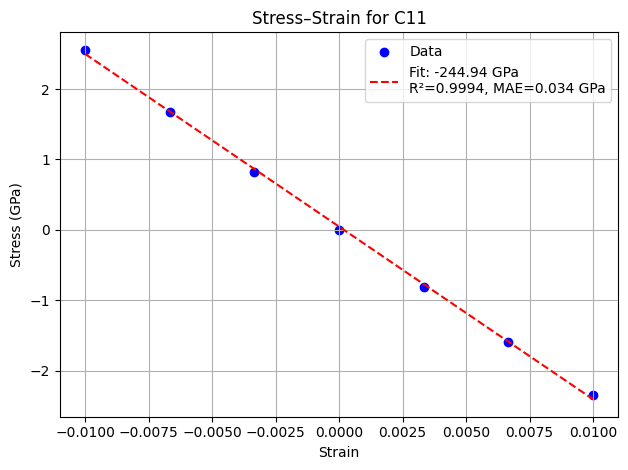

Calculating C12: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


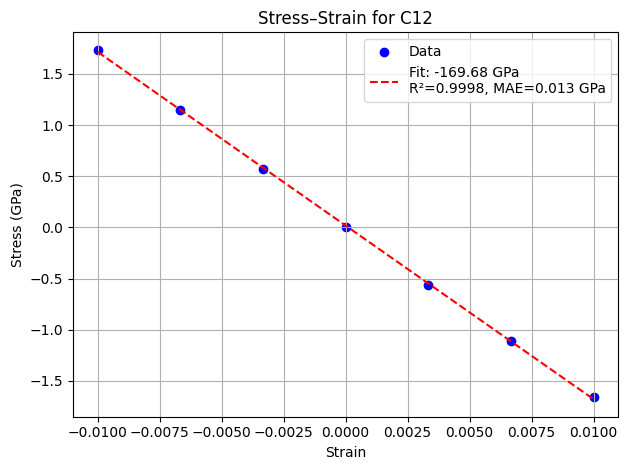

Calculating C44: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


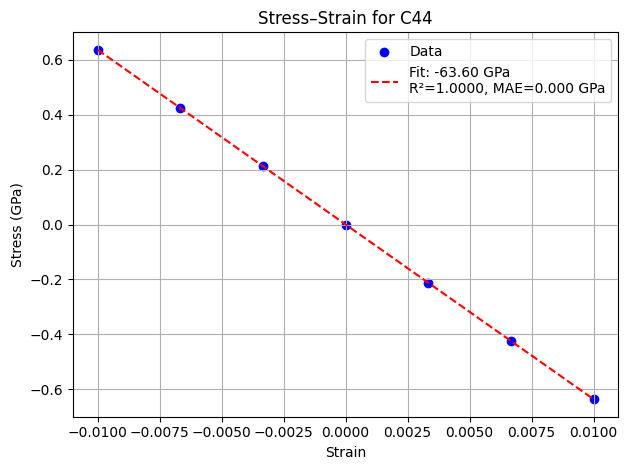


Elastic constants and fit quality:
Label    C (GPa)           R²       MAE (GPa)
----------------------------------------
C11      -244.94     0.999378        0.033914
C12      -169.68     0.999817        0.012862
C44       -63.60     1.000000        0.000207

(C11 - C12)/2 = -37.63 GPa


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ase.optimize import BFGS
from ase.lattice.cubic import BodyCenteredCubic
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# --- User parameters ---
num_points = 7
max_strain = 0.01      # ±1% strain
fmax_relax = 0.0001
bfgs_steps = 2000
relax_internal = True
EVA3_to_GPa = 160.21766208

# --- Initialize BCC Ta ---
atoms = BodyCenteredCubic('Ta')
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

# Fully relax the structure
atoms.calc = calc
opt = BFGS(atoms, logfile=None)
opt.run(fmax=0.0001, steps=bfgs_steps)
cell0 = atoms.get_cell().copy()

# --- Compute zero-strain stress ---
atoms.set_cell(cell0, scale_atoms=True)
atoms.calc = calc
calc.relax_cell = False
if relax_internal:
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=fmax_relax, steps=bfgs_steps)

stress_zero = atoms.get_stress(voigt=False)  # to shift all stresses

# --- Strain types ---
strain_types = {
    "C11": {"type": "normal", "strain_dir": 0, "stress_dir": 0},
    "C12": {"type": "normal", "strain_dir": 0, "stress_dir": 1},
    "C44": {"type": "shear",  "strain_dir": (0, 1), "stress_dir": (0, 1)},
}

C_results = {}
R2_results = {}
MAE_results = {}

# --- Loop over strain types ---
for label, info in strain_types.items():
    strains = np.linspace(-max_strain, max_strain, num_points)
    stresses = []

    for eps in tqdm(strains, desc=f"Calculating {label}"):
        strain_matrix = np.eye(3)

        # Build deformation
        if info["type"] == "shear":
            i, j = info["strain_dir"]
            strain_matrix[i, j] = eps
        else:
            i = info["strain_dir"]
            strain_matrix[i, i] = 1 + eps

        # Apply strain
        new_cell = np.dot(cell0, strain_matrix)
        atoms.set_cell(new_cell, scale_atoms=True)
        atoms.calc = calc
        calc.relax_cell = False

        # Relax internal coordinates only
        if relax_internal:
            opt = BFGS(atoms, logfile=None)
            opt.run(fmax=fmax_relax, steps=bfgs_steps)

        # Get stress component and subtract zero-strain stress
        stress = atoms.get_stress(voigt=False) - stress_zero
        if info["type"] == "shear":
            i, j = info["stress_dir"]
            val = float(stress[i, j])
        else:
            i = info["stress_dir"]
            val = float(stress[i, i])

        # --- Flip sign for all to match DFT negative slopes ---
        val = -val
        stresses.append(val)

    stresses = np.array(stresses)

    # --- Linear regression ---
    coeffs = np.polyfit(strains, stresses, 1)
    fit_line = np.polyval(coeffs, strains)
    C_value = coeffs[0] * EVA3_to_GPa
    C_results[label] = C_value

    # --- Goodness of fit ---
    ss_res = np.sum((stresses - fit_line) ** 2)
    ss_tot = np.sum((stresses - np.mean(stresses)) ** 2)
    r2 = 1 - ss_res / ss_tot
    R2_results[label] = r2

    mae = np.mean(np.abs((stresses - fit_line) * EVA3_to_GPa))
    MAE_results[label] = mae

    # --- Plot ---
    plt.figure()
    plt.scatter(strains, stresses * EVA3_to_GPa, color='blue', label='Data')
    plt.plot(strains, fit_line * EVA3_to_GPa, 'r--', 
             label=f'Fit: {C_value:.2f} GPa\nR²={r2:.4f}, MAE={mae:.3f} GPa')
    plt.xlabel('Strain')
    plt.ylabel('Stress (GPa)')
    plt.title(f'Stress–Strain for {label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Final results ---
print("\nElastic constants and fit quality:")
print(f"{'Label':<5} {'C (GPa)':>10} {'R²':>12} {'MAE (GPa)':>15}")
print("-" * 40)
for k in C_results:
    print(f"{k:<5} {C_results[k]:>10.2f} {R2_results[k]:>12.6f} {MAE_results[k]:>15.6f}")

if 'C11' in C_results and 'C12' in C_results:
    print("\n(C11 - C12)/2 = {:.2f} GPa".format((C_results['C11'] - C_results['C12'])/2))
